In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear_model
import scipy.stats as stats
import statsmodels.formula.api as sm
%matplotlib inline

In [155]:
#Loading and cleaning data

df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')
df = df.drop(df.index[0:4]).drop(df.index[-3:])
df.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','agg_assault',
                       'property_crime','burglary','larceny','motor_theft','arson']
df = df.drop('rape_revised', axis=1)
df = df.fillna(0)
df.index = range(len(df))

print(len(df))
df.head()

348


,city,population,violent_crime,murder,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny,motor_theft,arson
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0
3,Albany,97956,791,8,30,227,526,4090,705,3243,142,0
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,0


In [78]:
#Creating simple features for all columns of DataFrame (don't judge me, Nick)

features = pd.DataFrame(df['population'])
features['pop_winsorized'] = stats.mstats.winsorize(features.population, limits=.1)
features['population_sq'] = df.population**2
features['pop_winsorized_sq'] = features.pop_winsorized**2
features['voilent_crime'] = np.where(df.violent_crime>0, 1, 0)
features['murder'] = np.where(df.murder>0, 1, 0)
features['rape_legacy'] = np.where(df.rape_legacy>0, 1, 0)
features['robbery'] = np.where(df.robbery>0, 1, 0)
features['agg_assault'] = np.where(df.agg_assault>0, 1, 0)
features['property_crime'] = np.where(df.property_crime>0, 1, 0)
features['burglary'] = np.where(df.burglary>0, 1, 0)
features['larceny'] = np.where(df.larceny>0, 1, 0)
features['motor_theft'] = np.where(df.motor_theft>0, 1, 0)
features['arson'] = np.where(df.arson>0, 1, 0)

foo = features
foo = foo.drop('population', axis=1).drop('population_sq', axis=1).drop('pop_winsorized', axis=1).drop('pop_winsorized_sq', axis=1)
features['total'] = foo.sum(axis=1)

features.head()

,population,pop_winsorized,population_sq,pop_winsorized_sq,voilent_crime,murder,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny,motor_theft,arson,total
0,1861,1861,3463321,3463321,0,0,0,0,0,1,1,1,0,0,3
1,2577,2577,6640929,6640929,1,0,0,0,1,1,1,1,1,0,6
2,2846,2846,8099716,8099716,1,0,0,0,1,1,1,1,0,0,5
3,97956,36369,9595377936,1322704161,1,1,1,1,1,1,1,1,1,0,9
4,6388,6388,40806544,40806544,1,0,1,1,1,1,1,1,1,0,8


In [79]:
standard_df = pd.DataFrame()
standard_df['population'] = (df['population']-df['population'].mean())/df['population'].std()
standard_df['population_sq'] = (features.population_sq-features.population_sq.mean())/features.population_sq.std()
standard_df['violent_crime'] = (df['violent_crime']-df['violent_crime'].mean())/df['violent_crime'].std()
standard_df['murder'] = (df['murder']-df['murder'].mean())/df['murder'].std()
standard_df['rape_legacy'] = (df['murder']-df['murder'].mean())/df['murder'].std()
standard_df['robbery'] = (df['robbery']-df['robbery'].mean())/df['robbery'].std()
standard_df['agg_assault'] = (df['agg_assault']-df['agg_assault'].mean())/df['agg_assault'].std()
standard_df['property_crime'] = (df['property_crime']-df['property_crime'].mean())/df['property_crime'].std()
standard_df['burglary'] = (df['burglary']-df['burglary'].mean())/df['burglary'].std()
standard_df['larceny'] = (df['larceny']-df['larceny'].mean())/df['larceny'].std()
standard_df['motor_theft'] = (df['motor_theft']-df['motor_theft'].mean())/df['motor_theft'].std()
standard_df['arson'] = (df['arson']-df['arson'].mean())/df['arson'].std()

standard_df.head()

,population,population_sq,violent_crime,murder,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny,motor_theft,arson
0,-0.084830,-0.053866,-0.071608,-0.085562,-0.085562,-0.070708,-0.071074,-0.101910,-0.127233,-0.098804,-0.089001,-0.127558
1,-0.083239,-0.053865,-0.070542,-0.085562,-0.085562,-0.070708,-0.069316,-0.100344,-0.126152,-0.097228,-0.086522,-0.127558
2,-0.082641,-0.053864,-0.070542,-0.085562,-0.085562,-0.070708,-0.069316,-0.101388,-0.128314,-0.098016,-0.089001,-0.127558
3,0.128697,-0.051327,0.209360,0.351509,0.351509,0.149460,0.237226,0.430485,0.632809,0.410646,0.262986,-0.127558
4,-0.074771,-0.053856,-0.063438,-0.085562,-0.085562,-0.066828,-0.061696,-0.074364,-0.072095,-0.074380,-0.076607,-0.127558


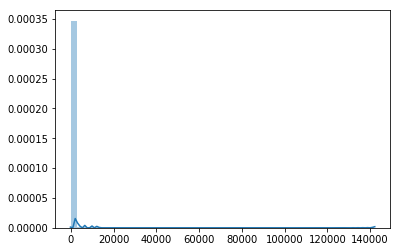

In [80]:
# 𝑃𝑟𝑜𝑝𝑒𝑟𝑡𝑦𝑐𝑟𝑖𝑚𝑒 = 𝛼 + 𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛 + 𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛^2 + 𝑀𝑢𝑟𝑑𝑒𝑟 + 𝑅𝑜𝑏𝑏𝑒𝑟𝑦
sns.distplot(list(df.property_crime))

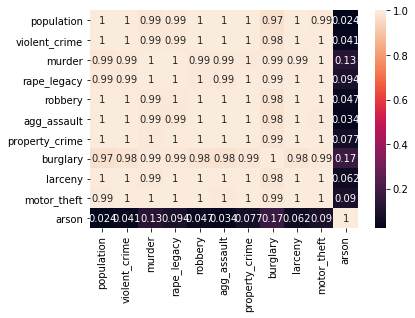

In [81]:
# Goal: Build a model to predict property crime
sns.heatmap(df.corr(), annot=True)

### Regression Model 1

In [82]:
# 𝑃𝑟𝑜𝑝𝑒𝑟𝑡𝑦𝑐𝑟𝑖𝑚𝑒 = 𝛼 + 𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛 + 𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛2 + 𝑀𝑢𝑟𝑑𝑒𝑟 + 𝑅𝑜𝑏𝑏𝑒𝑟𝑦

X = features[['population','population_sq','murder','robbery']]
Y = df['property_crime'].values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('\nR-squared: \n', regr.score(X, Y))

Intercept: 
 [-109.57533562]
Coefficients: 
 [[ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]]

R-squared: 
 0.9961247104988709


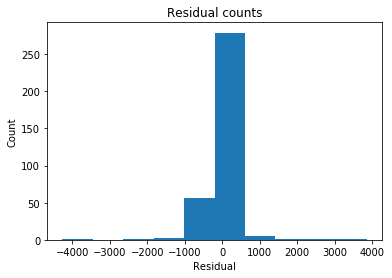

In [83]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

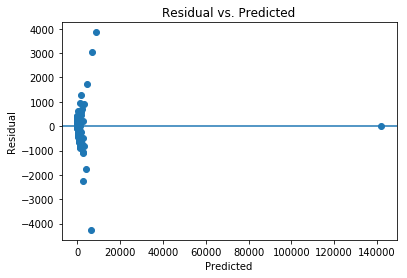

In [84]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

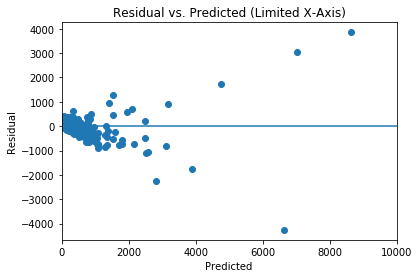

In [85]:
plt.scatter(predicted, residual)
plt.xlim(0, 10000)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (Limited X-Axis)')
plt.show()

In [86]:
X.corr()

,population,population_sq,murder,robbery
population,1.000000,0.998264,0.162309,0.064371
population_sq,0.998264,1.000000,0.133067,0.043983
murder,0.162309,0.133067,1.000000,0.313271
robbery,0.064371,0.043983,0.313271,1.000000


### Regression Model 2

In [87]:
features['property_crime_log'] = df['property_crime'].replace(0,1)
features['property_crime_log'] = np.log(np.int64(features['property_crime_log']))
features['property_crime_winsorized'] = stats.mstats.winsorize(df.property_crime, limits=.1)

In [88]:
# 𝑃𝑟𝑜𝑝𝑒𝑟𝑡𝑦𝑐𝑟𝑖𝑚𝑒 = 𝛼 + 𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛 (Winsorized) + 𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛^2 (Winsorized) + 𝑀𝑢𝑟𝑑𝑒𝑟 + 𝑅𝑜𝑏𝑏𝑒𝑟𝑦

X = features[['pop_winsorized','pop_winsorized_sq','murder','robbery']]
Y = features['property_crime_winsorized'].values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('\nR-squared: \n', regr.score(X, Y))

Intercept: 
 [-7.47395524]
Coefficients: 
 [[1.03650408e-02 1.92161186e-07 1.09908997e+02 9.54165389e+01]]

R-squared: 
 0.7820096386716618


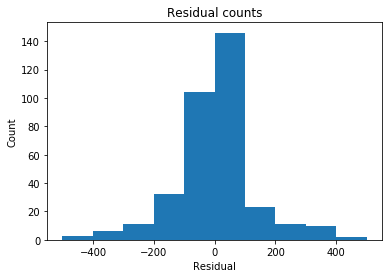

In [89]:
predicted = regr.predict(X).ravel()
actual = features['property_crime_winsorized']

residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

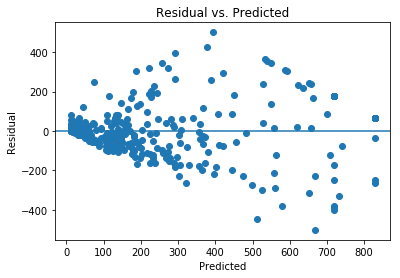

In [90]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [91]:
X.corr()

,pop_winsorized,pop_winsorized_sq,murder,robbery
pop_winsorized,1.000000,0.971392,0.529525,0.528494
pop_winsorized_sq,0.971392,1.000000,0.545179,0.447906
murder,0.529525,0.545179,1.000000,0.313271
robbery,0.528494,0.447906,0.313271,1.000000


### Regression Model 3

In [124]:
# 𝑃𝑟𝑜𝑝𝑒𝑟𝑡𝑦𝑐𝑟𝑖𝑚𝑒 = 𝛼 + 𝑃𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛 + 𝑀𝑢𝑟𝑑𝑒𝑟 + Burglary

X = standard_df[['population','murder','burglary','larceny']]
Y = standard_df['property_crime'].values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('\nR-squared: \n', regr.score(X, Y))

Intercept: 
 [-1.45553544e-17]
Coefficients: 
 [[0.0399113  0.01373753 0.1435746  0.80510208]]

R-squared: 
 0.9999975909517288


In [125]:
model = sm.ols(formula='property_crime ~ population+murder+robbery', data=df)
fitted1 = model.fit()
fitted1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 7.027e+04
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:49:25   Log-Likelihood:                -2488.7
No. Observations:                 348   AIC:                             4985.
Df Residuals:                     344   BIC:                             5001.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     87.0658     19.948      4.365      0.000      47.830     126.302
population     0.0122      0.001     12.162      0.000       0.010       0.014
murder       228.4894     11.625     19.655      0.000     205.624     251.355
robbery       -1.9239      0.605     -3.179      0.002      -3.114      -0.734
==============================================================================
Omnibus:                      165.960   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2111.887
Skew:                           1.642   Prob(JB):                         0.00
Kurtosis:                      14.613   Cond. No.                     5.67e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

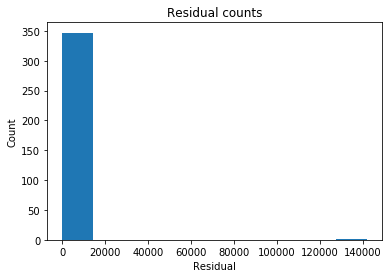

In [93]:
predicted = regr.predict(X).ravel()
actual = df.property_crime

residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [154]:
print(residual[residual == residual.max()])
df.iloc[216, :]

216    141952.554722
Name: property_crime, dtype: float64


city              New York
population         8396126
violent_crime        52384
murder                 335
rape_legacy           1112
robbery              19170
agg_assault          31767
property_crime      141971
burglary             16606
larceny             117931
motor_theft           7434
arson                    0
Name: 216, dtype: object

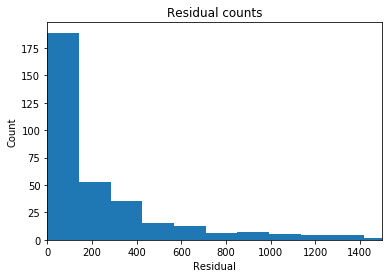

In [145]:
plt.hist(residual, bins=1000)
plt.xlim(0, 1500)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

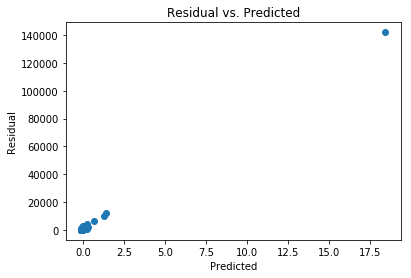

In [152]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual vs. Predicted')
plt.show()

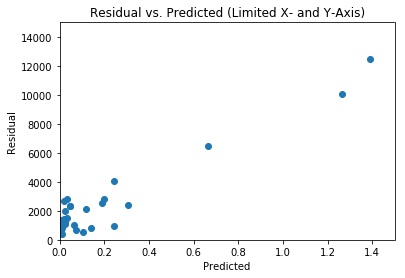

In [153]:
plt.scatter(predicted, residual)
plt.xlim(0, 1.5)
plt.ylim(0,15000)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual vs. Predicted (Limited X- and Y-Axis)')
plt.show()

In [126]:
X.corr()

,population,murder,burglary,larceny
population,1.000000,0.986758,0.970578,0.997946
murder,0.986758,1.000000,0.993733,0.993175
burglary,0.970578,0.993733,1.000000,0.982700
larceny,0.997946,0.993175,0.982700,1.000000


In conclusion, **regression model 3** explains the greatest amount of variance with four independent variables: R-squared and adjusted R-squared are both calculated as 99.8%. While this model is at risk of overfitting, it provides the most accuracy in terms of prediction. 

The city of New York has the largest residual by far with 141952.554722; however, considering it is a considerable outlier (the only city in the data with that large of a population), it would be unwise to compromise accuracy of the cities with average population size for the sake of 1 data point amidst 347 others. Moreover, considering there are no comparable cities to New York in this data set, if one was more concerned with predicting the property crime rate of New York it would be more beneficial to compare these points in a data set withthe data points of larger cities throughout the United States.